<div class="alert alert-block alert-warning">

<h1>Churn</h1>
    
<a href="https://www.kaggle.com/datasets/shrutimechlearn/churn-modelling">Kaggle Link</a>

    
<h2>About Dataset</h2>
<p>Content</p>
<blockquote>
This data set contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customer left the bank (closed his account) or he continues to be a customer.
</blockquote>
</div>

<hr>

<div class="alert alert-block alert-info">
    <h2>Columns</h2>
    <p><strong>CustomerID:</strong> Customer ID.</p>
    <p><strong>Surname:</strong> Customer's last name</p>
    <p><strong>CreditScore:</strong> Credit score of the customer.</p>
    <p><strong>Geography:</strong> The country from which the customer belongs.</p>
    <p><strong>Gender:</strong> Male or Female.</p>
    <p><strong>Age:</strong> Age of the customer.</p>
    <p><strong>Tenure:</strong> Number of years for which the customer has been with the bank.</p>
    <p><strong>Balance:</strong> Balance of the customer.</p>
    <p><strong>NumOfProducts:</strong> Number of bank products the customer is utilising.</p>
    <p><strong>HasCrCard:</strong>  Binary Flag for whether the customer holds a credit card with the bank or not.</p>
    <p><strong>IsActiveMember:</strong> Binary Flag for whether the customer is an active member with the bank or not.</p>
    <p><strong>EstimatedSalary:</strong> Estimated salary of the customer in Dollars.</p>
    <p><strong>Exited:</strong> Binary flag 1 if the customer closed account with bank and 0 if the customer is retained.</p>
</div>

## Importing Libraries

In [1]:
import findspark
findspark.init("C:\spark")

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark import SparkContext

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from pyspark.sql.functions import explode, array, lit

from pyspark.ml.feature import StringIndexer

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.classification import GBTClassifier

In [5]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

## Create Spark

In [6]:
spark = SparkSession.builder.master("local").appName("churn").getOrCreate()
sc = spark.sparkContext

In [7]:
sc

<SparkContext master=local appName=churn>

## Importing Dataset

In [8]:
df = spark.read.csv("Churn_Modelling.csv",header=True,inferSchema=True)
df.cache()

DataFrame[RowNumber: int, CustomerId: int, Surname: string, CreditScore: int, Geography: string, Gender: string, Age: int, Tenure: int, Balance: double, NumOfProducts: int, HasCrCard: int, IsActiveMember: int, EstimatedSalary: double, Exited: int]

In [9]:
print(f"Total NaN values : {df.count()-df.dropna().count()}")

Total NaN values : 0


In [10]:
df.columns

['RowNumber',
 'CustomerId',
 'Surname',
 'CreditScore',
 'Geography',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

- Dropping 'RowNumber' and 'Surname' columns

In [11]:
df = df.drop('RowNumber','Surname')

In [12]:
df.printSchema()

root
 |-- CustomerId: integer (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



- Converting colum names to lower

In [13]:
df = df.toDF(*[c.lower() for c in df.columns])

- Checking if there is not unique customer id

In [14]:
df.groupBy("customerid").count().sort("count",ascending = False).show(5)

+----------+-----+
|customerid|count|
+----------+-----+
|  15632264|    1|
|  15613854|    1|
|  15662403|    1|
|  15672012|    1|
|  15724563|    1|
+----------+-----+
only showing top 5 rows



In [15]:
df = df.drop("customerid")

- How many customers exited, how many customers not exited

In [16]:
df.groupBy("exited").count().show()

+------+-----+
|exited|count|
+------+-----+
|     1| 2037|
|     0| 7963|
+------+-----+



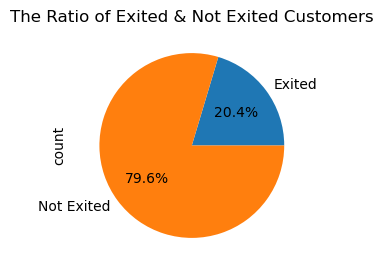

In [17]:
plt.figure(figsize = (5,3))
df.groupBy("exited").count().toPandas()['count'].plot.pie(
    autopct = "%.1f%%",
    labels = ['Exited','Not Exited'],
    title = "The Ratio of Exited & Not Exited Customers");

- Unique country names and counts

In [18]:
df.select("geography").drop_duplicates().show()

+---------+
|geography|
+---------+
|  Germany|
|   France|
|    Spain|
+---------+



In [19]:
df.groupBy("geography").count().show()

+---------+-----+
|geography|count|
+---------+-----+
|  Germany| 2509|
|   France| 5014|
|    Spain| 2477|
+---------+-----+



In [20]:
df.groupBy("geography").agg({'exited':"mean"}).show()

+---------+-------------------+
|geography|        avg(exited)|
+---------+-------------------+
|  Germany|0.32443204463929853|
|   France|0.16154766653370561|
|    Spain| 0.1667339523617279|
+---------+-------------------+



In [21]:
df.show(5)

+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|creditscore|geography|gender|age|tenure|  balance|numofproducts|hascrcard|isactivemember|estimatedsalary|exited|
+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|
|        850|    Spain|Female| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|
+-----------+---------+------+---+------+---------+-------------+---------+-------------

## Data Preporcessing

In [22]:
df.groupBy("exited").count().show() #ubbalanced labels

+------+-----+
|exited|count|
+------+-----+
|     1| 2037|
|     0| 7963|
+------+-----+



In [23]:
minor_df = df.filter(df.exited == 1)
major_df = df.filter(df.exited == 0)

In [24]:
a = range(3)
# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')
# combine both oversampled minority rows and previous majority rows 
balanced_df = major_df.unionAll(oversampled_df)

In [25]:
balanced_df.groupBy("exited").count().show()

+------+-----+
|exited|count|
+------+-----+
|     0| 7963|
|     1| 6111|
+------+-----+



In [26]:
string_indexer = StringIndexer(inputCol="exited",outputCol="label") 

In [27]:
indexed = string_indexer.fit(balanced_df).transform(balanced_df)

In [28]:
indexed.dtypes

[('creditscore', 'int'),
 ('geography', 'string'),
 ('gender', 'string'),
 ('age', 'int'),
 ('tenure', 'int'),
 ('balance', 'double'),
 ('numofproducts', 'int'),
 ('hascrcard', 'int'),
 ('isactivemember', 'int'),
 ('estimatedsalary', 'double'),
 ('exited', 'int'),
 ('label', 'double')]

In [29]:
balanced_df = indexed.withColumn("label",indexed["label"].cast("integer"))

In [30]:
balanced_df.dtypes

[('creditscore', 'int'),
 ('geography', 'string'),
 ('gender', 'string'),
 ('age', 'int'),
 ('tenure', 'int'),
 ('balance', 'double'),
 ('numofproducts', 'int'),
 ('hascrcard', 'int'),
 ('isactivemember', 'int'),
 ('estimatedsalary', 'double'),
 ('exited', 'int'),
 ('label', 'int')]

In [31]:
balanced_df.show(5)

+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-----+
|creditscore|geography|gender|age|tenure|  balance|numofproducts|hascrcard|isactivemember|estimatedsalary|exited|label|
+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-----+
|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|    0|
|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|     0|    0|
|        850|    Spain|Female| 43|     2|125510.82|            1|        1|             1|        79084.1|     0|    0|
|        822|   France|  Male| 50|     7|      0.0|            2|        1|             1|        10062.8|     0|    0|
|        501|   France|  Male| 44|     4|142051.07|            2|        0|             1|        74940.5|     0|    0|
+-----------+---------+------+---+------

## Creating Independent and Dependent Variables

In [32]:
bag = ['creditscore','age','tenure','balance','numofproducts','hascrcard','isactivemember','estimatedsalary']

In [33]:
vectorAssembler = VectorAssembler(inputCols = bag,outputCol='features')

In [34]:
va_df =vectorAssembler.transform(balanced_df)

In [35]:
final_df = va_df.select("features","label")

In [36]:
final_df.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[608.0,41.0,1.0,8...|    0|
|[699.0,39.0,1.0,0...|    0|
|[850.0,43.0,2.0,1...|    0|
|[822.0,50.0,7.0,0...|    0|
|[501.0,44.0,4.0,1...|    0|
+--------------------+-----+
only showing top 5 rows



## Creating Train and Test Sets

In [37]:
splits = final_df.randomSplit([0.7,0.3])

In [38]:
train_df = splits[0]
test_df = splits[1]

In [39]:
train_df.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(8,[0,1,4,7],[538...|    0|
|(8,[0,1,4,7],[585...|    0|
|(8,[0,1,4,7],[619...|    0|
+--------------------+-----+
only showing top 3 rows



In [40]:
test_df.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(8,[0,1,4,7],[502...|    0|
|(8,[0,1,4,7],[575...|    0|
|(8,[0,1,4,7],[631...|    0|
+--------------------+-----+
only showing top 3 rows



## Classification

In [41]:
gbm = GBTClassifier(maxIter = 10,featuresCol="features",labelCol="label")
gbm_model = gbm.fit(train_df)

In [42]:
y_pred = gbm_model.transform(test_df)

In [43]:
ac = y_pred.select("label","prediction")
print("Accuracy :",round(ac.filter(ac.label == ac.prediction).count() / ac.count(),2))

Accuracy : 0.78


### Model Tuning

In [44]:
evaluator = BinaryClassificationEvaluator()

In [45]:
param_grid = (
    ParamGridBuilder()
    .addGrid(gbm.maxDepth,[2,4,6])
    .addGrid(gbm.maxIter,[10,20])
    .build()
)

cv = CrossValidator(
    estimator=gbm,estimatorParamMaps=param_grid,evaluator=evaluator,numFolds=2
)

In [46]:
cv_model = cv.fit(train_df)

In [47]:
y_pred = cv_model.transform(test_df)

In [48]:
ac = y_pred.select("label","prediction")
print("Accuracy (after model tuning):",round(ac.filter(ac.label == ac.prediction).count() / ac.count(),2))

Accuracy (after model tuning): 0.78


## Multiple Customer Forecasts

In [49]:
data = {
    'fullname':["Customer 1","Customer 2"],
    'creditscore':[653, 608],
    'age':[58, 41],
    'tenure':[1, 1],
    'balance':[132602.88, 83807.86],
    'numofproducts':[1, 1],
    'hascrcard':[1, 0],
    'isactivemember':[0, 1],
    'estimatedsalary':[5097.67, 112542.58]
}

prediction_df = spark.createDataFrame(pd.DataFrame.from_dict(data))

print("Data".center(100,'_'),end = '\n\n')
prediction_df.show()

________________________________________________Data________________________________________________

+----------+-----------+---+------+---------+-------------+---------+--------------+---------------+
|  fullname|creditscore|age|tenure|  balance|numofproducts|hascrcard|isactivemember|estimatedsalary|
+----------+-----------+---+------+---------+-------------+---------+--------------+---------------+
|Customer 1|        653| 58|     1|132602.88|            1|        1|             0|        5097.67|
|Customer 2|        608| 41|     1| 83807.86|            1|        0|             1|      112542.58|
+----------+-----------+---+------+---------+-------------+---------+--------------+---------------+



In [50]:
prediction_vec = vectorAssembler.transform(prediction_df)
result = cv_model.transform(prediction_vec)

print("Predictions".center(23,'_'),end = '\n\n')
result.select('fullname',"prediction").show()

______Predictions______

+----------+----------+
|  fullname|prediction|
+----------+----------+
|Customer 1|       1.0|
|Customer 2|       0.0|
+----------+----------+



## Stop Spark

In [51]:
if input("Press 'e' to stop Spark: ") == 'e':
    sc.stop()

Press 'e' to stop Spark: e
